In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import abc
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [106]:
from diffusion import ExactScoreNetwork, DiffusionModel, ContinuousSBM, ContinuousVPSDE, linear_schedule, power_law_schedule, EulerMaruyama
from hmc import HMC
from hmc_utils import collision_manager, boundary_projection

In [107]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [203]:
## Dummy GMM dataset.
# Centers are going to be located on each lattice point of a 5x5 grid.
ndim = 2
sqrt_n_centers = 5
centers = torch.tensor([[i, j] for i in range(sqrt_n_centers) for j in range(sqrt_n_centers)], dtype=torch.float32)
centers -=torch.tensor([1,1])*(sqrt_n_centers-1)/2
n_centers = centers.shape[0]

weights = torch.ones(n_centers)/n_centers

stds = torch.ones(n_centers, 1) * 0.1

def sample(n_samples):
    center_idxs = torch.multinomial(weights, n_samples, replacement=True)
    samples = centers[center_idxs] + torch.randn(n_samples, ndim) * stds[center_idxs]
    return samples

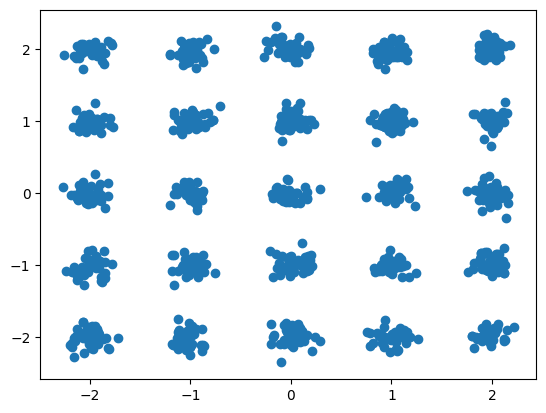

In [204]:
## Sample 1000 points from the GMM.

n_samples = 1000
data = sample(n_samples)

#Plot the data
plt.scatter(data[:,0], data[:,1])

In [205]:
# If you want to train something...
train = False
if train:
    n_dataset = 100000
    data = sample(n_dataset)
    split = int(n_dataset*0.8)
    train_data = data[:split]
    test_data = data[split:]

    train_dataset = torch.utils.data.TensorDataset(train_data)
    test_dataset = torch.utils.data.TensorDataset(test_data)

    batch_size = 1000

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [206]:
sde = ContinuousVPSDE()

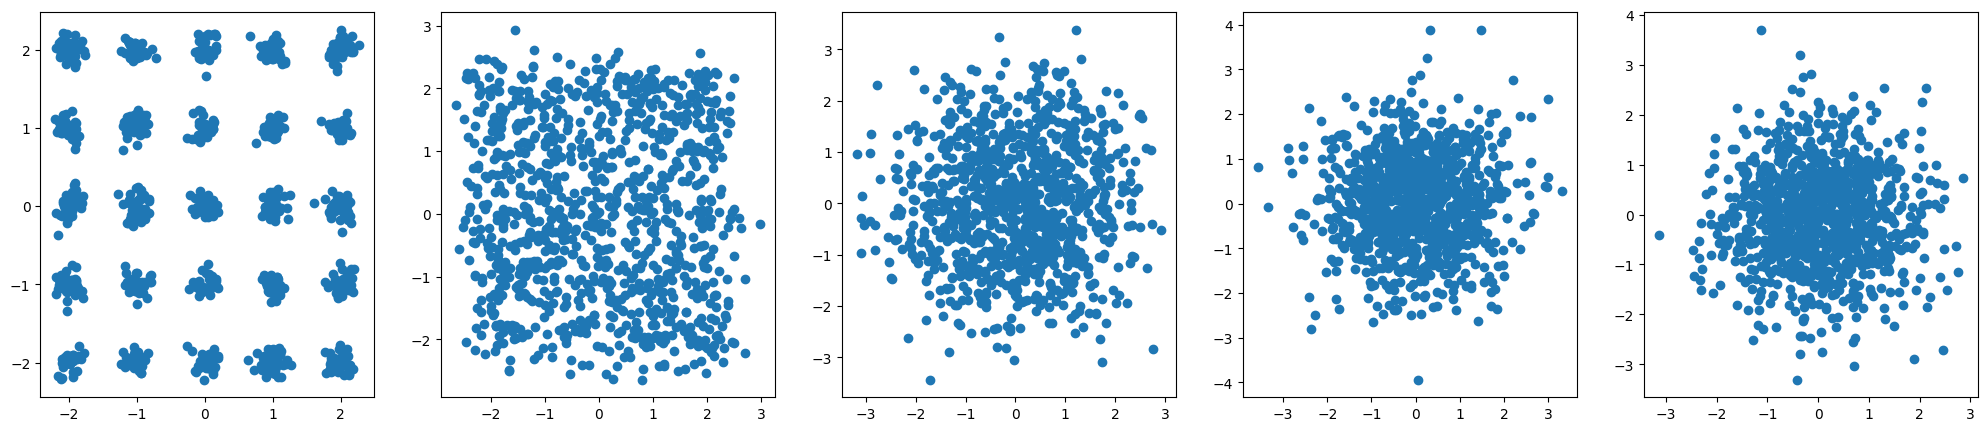

In [207]:
# Test the sde object sampling method for different timesteps (0, 0.1, 0.3, 0.5 and 1)
fig, ax = plt.subplots(1, 5, figsize = (25, 5))
times = [0, 0.1, 0.3, 0.5, 1]
samples = sample(1000)
for i, t in enumerate(times):
    timesteps = torch.ones(1000)*t
    noisy_samples, _, _ = sde.sampling(samples, timesteps)
    ax[i].scatter(noisy_samples[:,0], noisy_samples[:,1])

In [208]:
exact_score_net = ExactScoreNetwork(centers, stds, weights).to(device)
exact_dm = ContinuousSBM(sde, exact_score_net).to(device)

In [209]:
## Generate 1000 datapoints and plot them
n_samples = 10000
t = torch.ones(n_samples).to(device)*1
tmin = torch.ones(n_samples).to(device)*sde.tmin
schedule = power_law_schedule(t_min = tmin, t_max = t, n_iter = 1000, power = 2)
samples = exact_dm.generate_image(n_samples, schedule = schedule.to(device))

In [210]:
samples = samples.cpu().detach().numpy()

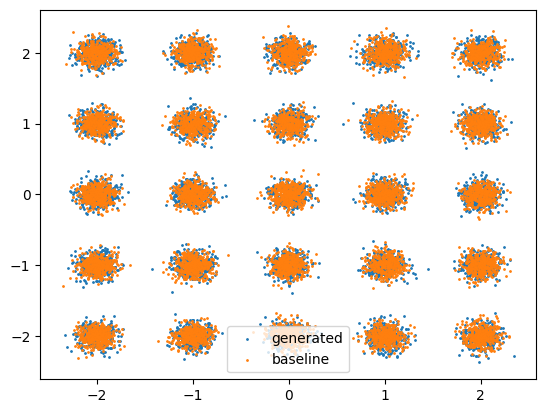

In [211]:
## Plot generated samples
plt.scatter(samples[:,0], samples[:,1], label = 'generated', s=1)
baseline = sample(n_samples).cpu().numpy()
plt.scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1)
plt.legend()

Text(0.5, 1.0, 'Baseline')

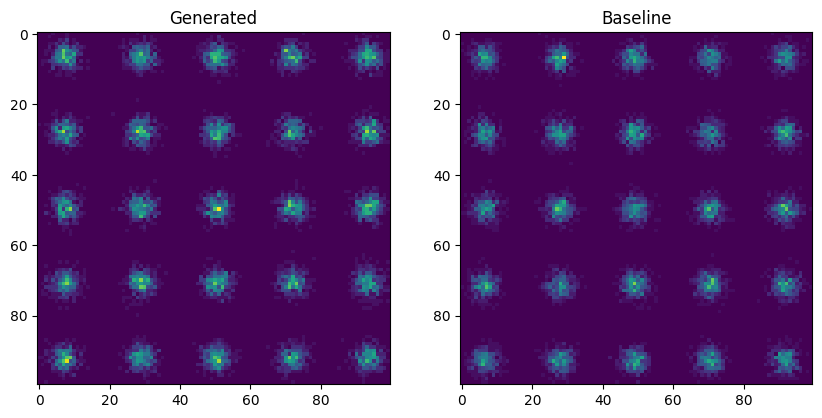

In [212]:
## Plot the empirical distribution of the generated samples and the baseline

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
hist_generated = np.histogram2d(samples[:,0], samples[:,1], bins = 100)
hist_baseline = np.histogram2d(baseline[:,0], baseline[:,1], bins = 100)
ax[0].imshow(hist_generated[0])
ax[0].set_title('Generated')
ax[1].imshow(hist_baseline[0])
ax[1].set_title('Baseline')


# Inverse problem

### Linear

In [213]:
n_samples = 1000

In [214]:
prior = sample(n_samples).to(device)

In [215]:
## Linear operator for inverse problems

theta = np.pi/3

vector = torch.tensor([np.cos(theta), np.sin(theta)]).to(device).reshape(-1, 1)

A = vector @ vector.T
A = A.to(torch.float32)

forward_model = lambda x: x @ A.T

sigma_y = 0.1
## Generate 1000 datapoints and plot their projections

observation_prior = prior @ A.t() + torch.randn(n_samples, 2).to(device)*sigma_y

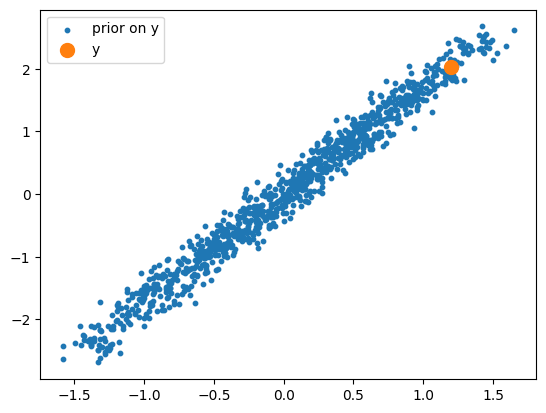

In [216]:
x_truth = sample(1).to(device)
y = x_truth @ A.t() + torch.randn(1, 2).to(device)*sigma_y

plt.scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label = 'prior on y', s=10)
plt.scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'y', s=100)
plt.legend()

In [217]:
## Only works with even stds?
def true_posterior_sampling(centers, stds, weights, y, A, sigma_y, n_samples):
    centers, stds, weights = centers.to(device), stds.to(device), weights.to(device)
    A, y = A.to(device), y.to(device)


    projected_centers = centers.to(device) @ A.to(device).T
    projected_covs = stds.reshape(-1, 1,1)**2 * (A @ A.T).reshape(1,2,2) + sigma_y**2 * torch.eye(2).reshape(1,2,2).to(device)

    projected_y_rescaled = y - projected_centers
    quadratic = torch.einsum('ki, kij, kj -> k', projected_y_rescaled, torch.inverse(projected_covs), projected_y_rescaled)

    weights_modifier = torch.exp(-1/2*quadratic)/torch.sqrt(torch.det(projected_covs))
    weights_modified = weights * weights_modifier
    weights_modified = weights_modified/weights_modified.sum()
    
    Sigma = torch.inverse((torch.eye(2).to(device)/stds.reshape(-1,1,1)**2) + A.T @ A / sigma_y**2)
    new_centers = (y @ A.T / sigma_y**2).reshape(1, 2) + centers/(stds**2).reshape(-1, 1)
    new_centers = torch.einsum('bi, bij -> bj', new_centers, Sigma)
    centers_idx = torch.multinomial(weights_modified, n_samples, replacement=True)
    samples = new_centers[centers_idx] + torch.einsum('bij, bj -> bi', torch.linalg.cholesky(Sigma[centers_idx]), torch.randn(n_samples, 2).to(device))
    return samples, new_centers, Sigma, weights_modified


In [218]:
posterior_samples, new_centers, Sigma, weights_modified = true_posterior_sampling(centers, stds, weights, y, A, sigma_y, 1000)

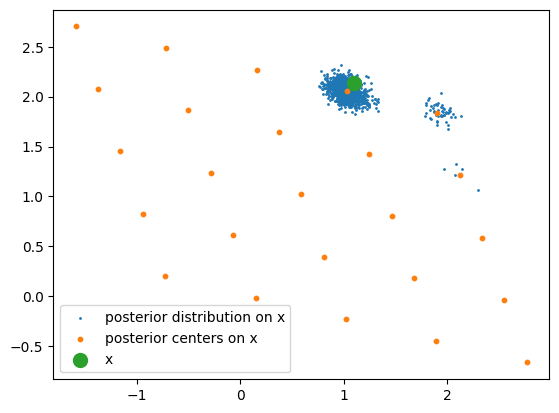

In [219]:
plt.scatter(posterior_samples.cpu()[:,0], posterior_samples.cpu()[:,1], label = 'posterior distribution on x', s=1)
plt.scatter(new_centers.cpu()[:,0], new_centers.cpu()[:,1], label = 'posterior centers on x', s=10)
plt.scatter(x_truth.cpu()[:,0], x_truth.cpu()[:,1], label = 'x', s=100)
plt.legend()

## DPS

In [220]:
def dps_sampling(diffusion_model, sample_size, observation, forward_model, solver, scale = "constant", verbose = False):
    diffusion_model.eval()
    if scale == "adaptive":
        def f(x_t, t):
            x_t.requires_grad_(True)
            model_output = diffusion_model.network(x_t, t)
            x_hat_0 = diffusion_model.sde.tweedie_reverse(x_t, t, model_output)
            g = torch.sum((forward_model(x_hat_0) - observation)**2)/sigma_y**2/2
            rescaling = torch.sqrt(1 - torch.exp(-diffusion_model.sde.Beta(t))).reshape(-1, 1)#**2##?
            guidance = torch.autograd.grad(g, x_t, create_graph=True)[0]*rescaling
            x_t = x_t.detach()
            if scale == "adaptive":
                return diffusion_model.sde.reverse(x_t, t, guidance+model_output)[0]
            elif scale == "constant":
                return diffusion_model.sde.reverse(x_t, t, model_output)[0]+guidance
            else:
                raise ValueError("Scale should be either 'constant' or 'adaptive'")
        def gdW(x_t, t):
            dummy_output = torch.zeros_like(x_t)
            return diffusion_model.sde.reverse(x_t, t, dummy_output)[1]
        
        x_init = diffusion_model.sde.prior_sampling((sample_size, diffusion_model.network.ndim)).to(device)
        gen = solver.forward(x_init, f, gdW, reverse_time = True, verbose = verbose)

    return gen

In [221]:
num_samples = 1000
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)

In [222]:
generated = dps_sampling(exact_dm, num_samples, y.to(device), forward_model, EulerMaruyama(schedule), scale = "adaptive")

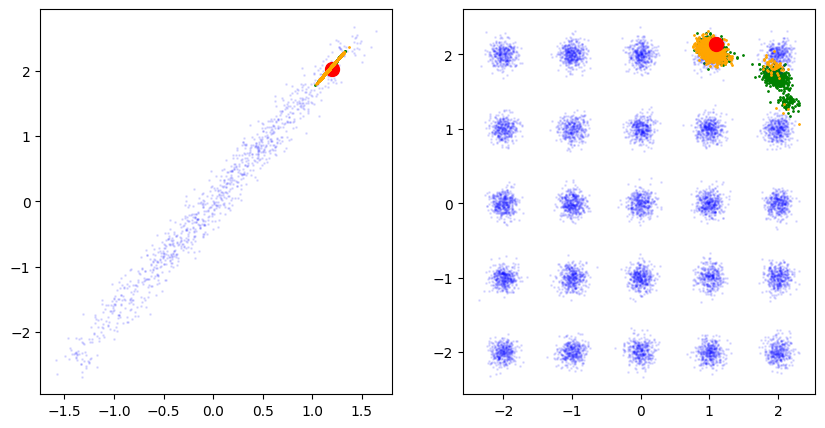

In [223]:
generated = generated.cpu().detach()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
generated_projection = generated @ A.t().to('cpu')
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')
posterior_projection = (posterior_samples @ A.T).cpu()
ax[0].scatter(posterior_projection[:,0], posterior_projection[:,1], label = 'posterior', s=1, color='orange')

ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')
ax[1].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')

## TDS

In [224]:
## A twisted diffusion sampler to solve the inverse problem.

def twisted_diffusion_sampler(diffusion_model, sample_size, observation, forward_model, schedule, verbose = False, smc = True):
    ess_list = []
    times = schedule.flip(1)
    diffusion_model.eval()
    ndim = diffusion_model.network.ndim
    x_t = diffusion_model.sde.prior_sampling((sample_size, ndim)).to(device)
    x_t.requires_grad_(True)
    t = times[:,0].to(device).unsqueeze(1)
    model_output = diffusion_model.network(x_t, t)
    x_hat_0 = diffusion_model.sde.tweedie_reverse(x_t, t, model_output)
    g = torch.sum((forward_model(x_hat_0) - observation)**2, dim=1)/sigma_y**2/2
    guidance = torch.autograd.grad(g.sum(), x_t, create_graph=True)[0]
    log_p_obs_given_x_t = - g
    log_weights = log_p_obs_given_x_t
    nsteps = times.shape[1]-1
    progress_bar = tqdm.tqdm(total=nsteps)
    memory_every = 100
    memory_samples = []
    memory_model_outputs = []
    memory_guidances = []
    for i in range(nsteps):
        with torch.no_grad():   
            if smc:
                weights = torch.softmax(0*log_weights, dim=0)
                idx = torch.multinomial(weights, sample_size, replacement=True)
                ess_list.append(1/(weights**2).sum().item())
                x_t = x_t[idx]
                guidance = guidance[idx]
            if i%memory_every == 0:
                memory_samples.append(x_t.cpu().detach().numpy())
                memory_model_outputs.append(model_output.cpu().detach().numpy())
                rescaling = torch.sqrt(1 - torch.exp(-diffusion_model.sde.Beta(t))).reshape(-1, 1)
                memory_guidances.append(guidance.cpu().detach().numpy()*rescaling.cpu().detach().numpy())
            t_1 = times[:,i+1].to(device).unsqueeze(1)
            dt = t_1 - t

            unconditional_drift, unconditional_diffusion = diffusion_model.sde.reverse(x_t, t, model_output)

            rescaling = torch.sqrt(1 - torch.exp(-diffusion_model.sde.Beta(t))).reshape(-1, 1)
            conditionnal_drift, _ = diffusion_model.sde.reverse(x_t, t, model_output + guidance*rescaling)
            beta_t = diffusion_model.sde.beta(t).reshape(-1, 1)
            std_diffusion = torch.sqrt(torch.abs(dt)*beta_t).reshape(-1)
            x_t_1 = x_t + conditionnal_drift*dt + unconditional_diffusion*torch.sqrt(torch.abs(dt))
        
            log_p_x_t_1_given_x_t = -torch.sum((x_t_1 - (x_t + unconditional_drift*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
            log_p_x_t_1_given_x_t_guidance = -torch.sum((x_t_1 - (x_t + conditionnal_drift*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
        x_t = x_t_1.detach()
        x_t.requires_grad_(True)

        model_output = diffusion_model.network(x_t, t_1)
        x_hat_0 = diffusion_model.sde.tweedie_reverse(x_t, t_1, model_output)
        g = torch.sum((forward_model(x_hat_0) - observation)**2, dim=1)/sigma_y**2/2
        guidance = torch.autograd.grad(g.sum(), x_t, create_graph=True)[0]
        log_p_obs_given_x_t_1 = - g 
        log_weights = log_p_x_t_1_given_x_t - log_p_x_t_1_given_x_t_guidance + log_p_obs_given_x_t_1- log_p_obs_given_x_t
        log_p_obs_given_x_t = log_p_obs_given_x_t_1
        t = t_1
        progress_bar.update(1)
    progress_bar.close()
    if smc:
        weights = torch.softmax(0*log_weights, dim=0)
        ess_list.append(1/(weights**2).sum().item())
        idx = torch.multinomial(weights, sample_size, replacement=True)
        return x_t[idx], ess_list, memory_samples
    else:
        return x_t, ess_list, memory_samples, memory_model_outputs, memory_guidances

In [225]:
num_samples = 40
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)

In [226]:
generated, ess, memory_samples, memory_mo, memory_g = twisted_diffusion_sampler(exact_dm, num_samples, y.to(device), forward_model, schedule, verbose = True, smc=False)

100%|██████████| 999/999 [00:02<00:00, 434.16it/s]


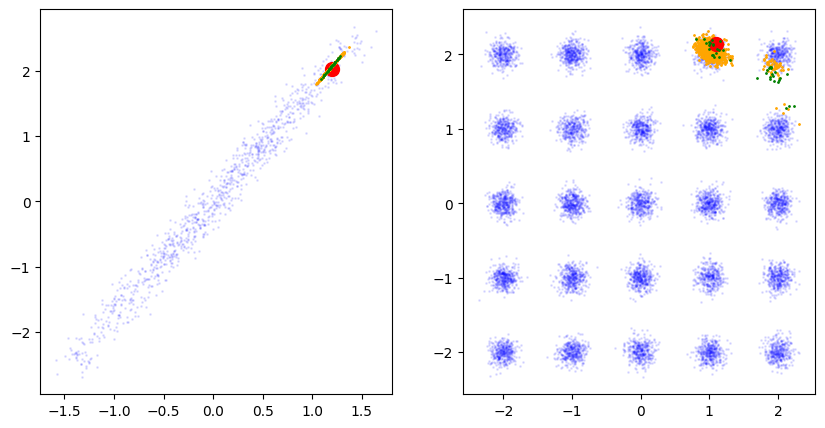

In [227]:
generated = generated.cpu().detach()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
posterior_projection = (posterior_samples @ A.T).cpu()
ax[0].scatter(posterior_projection[:,0], posterior_projection[:,1], label = 'posterior', s=1, color='orange')
generated_projection = generated @ A.t().to('cpu')
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')

ax[1].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

In [228]:
generated = generated.cpu().detach()

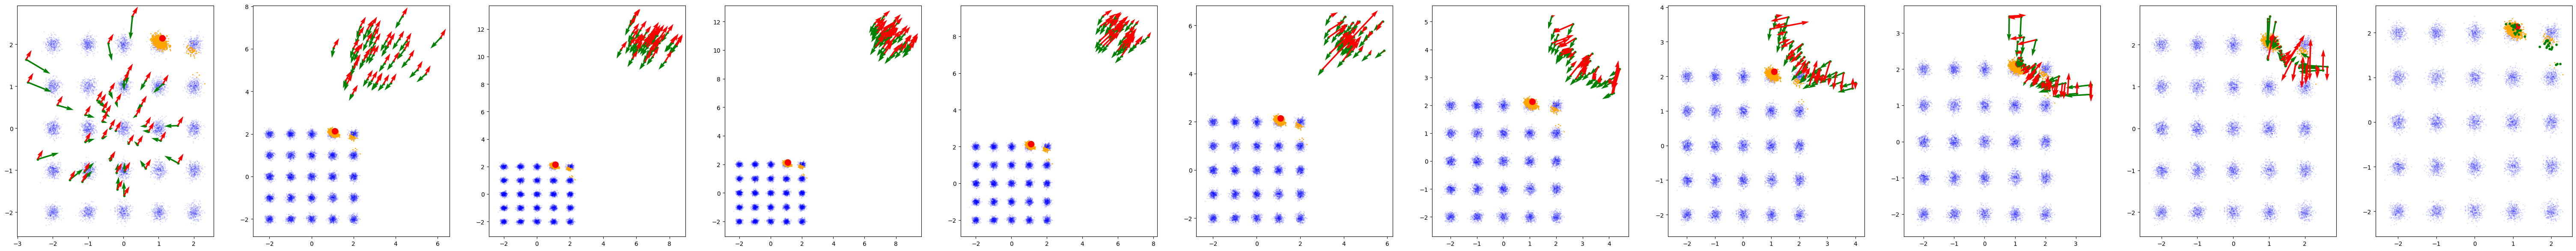

In [229]:
fig, ax = plt.subplots(1, len(memory_samples)+1, figsize = (7*(len(memory_samples)+1), 7))
for i in range(len(memory_samples)):
    ax[i].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
    ax[i].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
    ax[i].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
    ax[i].scatter(memory_samples[i][:,0], memory_samples[i][:,1], label = 'generated', s=10, color='green')
    # Vector plot of model outputs and then guidance
    ax[i].quiver(memory_samples[i][:,0], memory_samples[i][:,1], -memory_mo[i][:,0], -memory_mo[i][:,1], color='green')
    ax[i].quiver(memory_samples[i][:,0], memory_samples[i][:,1], -memory_g[i][:,0], -memory_g[i][:,1], color='red')

id = len(memory_samples)
ax[id].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[id].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[id].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[id].scatter(generated[:,0], generated[:,1], label = 'generated', s=10, color='green')

In [236]:
x_T = exact_dm.sde.prior_sampling((1,2)).to(device)
x_T

tensor([[-0.3342, -1.5125]], device='cuda:0')

In [237]:
timestep = torch.ones(1).to(device)*sde.tmax

model_output = exact_dm.network(x_T, timestep)

In [238]:
model_output

tensor([[-0.3342, -1.5124]], device='cuda:0', grad_fn=<MulBackward0>)

In [239]:
exact_dm.sde.tweedie_reverse(x_T, timestep, model_output)

tensor([[-0.0044, -0.0200]], device='cuda:0', grad_fn=<DivBackward0>)

In [231]:
exact_dm.sde.Beta(torch.tensor([1]))

tensor([10.0500])

In [233]:
torch.exp(-exact_dm.sde.Beta(torch.tensor([1])))

tensor([4.3186e-05])

In [234]:
exact_dm.sde.beta(torch.tensor([1]))

tensor([20.])

## $\Pi$-GDM

In [85]:
def guidance_linear_op(x_hat, y, r_t_2, sigma_y, A):
    error = (x_hat @ A.T - y)
    cov = (torch.eye(2).to(device)*sigma_y**2).reshape(1,2,2) + (A.T @ A).reshape(1,2,2)*r_t_2.reshape(-1, 1, 1)
    return 1/2*torch.einsum('bi, bij, bj -> b', error, torch.inverse(cov), error)

In [86]:
def pigdm_sampling(diffusion_model, sample_size, observation, A, solver, sigma_y, scale = "constant", verbose = False):
    diffusion_model.eval()
    if sigma_y == 0:
        sigma_y += 1e-6
    
    def f(x_t, t):
        x_t.requires_grad_(True)
        model_output = diffusion_model.network(x_t, t)
        x_hat_0 = diffusion_model.sde.tweedie_reverse(x_t, t, model_output)
        noise_level = diffusion_model.sde.noise_level(t)
        r_t_2 = noise_level**2/(1+noise_level**2)
        beta_t = diffusion_model.sde.beta(t).reshape(-1, 1)
        r_t_2 = (beta_t/(1+beta_t))
        curr_alpha = 1/(1+beta_t)
        g = guidance_linear_op(x_hat_0, observation, r_t_2, sigma_y, A)
        guidance = torch.autograd.grad(g.sum(), x_t, create_graph=True)[0]
        x_t = x_t.detach()
        if scale == "adaptive":
            return diffusion_model.sde.reverse(x_t, t, guidance+model_output)[0]
        elif scale == "constant":
            return diffusion_model.sde.reverse(x_t, t, model_output)[0]+guidance
        
    def gdW(x_t, t):
        dummy_output = torch.zeros_like(x_t)
        return diffusion_model.sde.reverse(x_t, t, dummy_output)[1]
    
    x_init = diffusion_model.sde.prior_sampling((sample_size, diffusion_model.network.ndim)).to(device)
    gen = solver.forward(x_init, f, gdW, reverse_time = True, verbose = verbose)

    return gen

        

In [87]:
pigdm_samples = pigdm_sampling(exact_dm, num_samples, y.to(device), A.to(device), EulerMaruyama(schedule), sigma_y, scale = "adaptive")

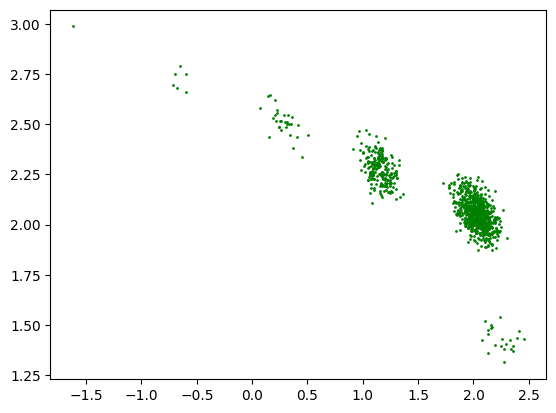

In [88]:
plt.scatter(pigdm_samples.detach().cpu()[:,0], pigdm_samples.detach().cpu()[:,1], label = 'pigdm', s=1, color='green')

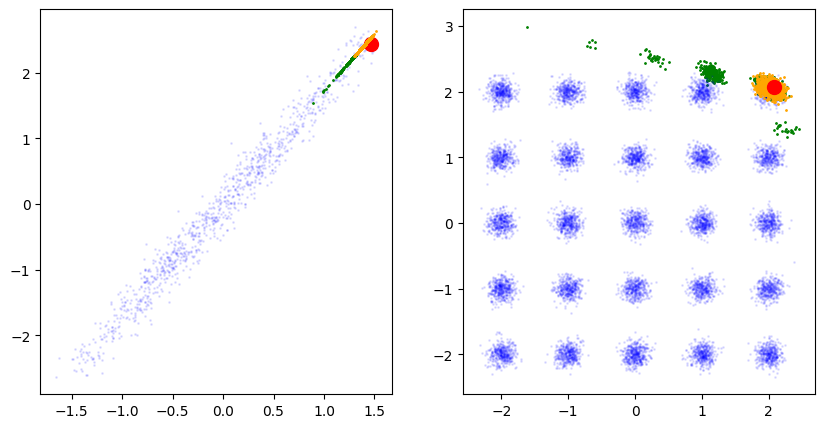

In [89]:
generated = pigdm_samples.detach().cpu()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
generated_projection = generated @ A.t().to('cpu')
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')
posterior_projection = (posterior_samples @ A.T).cpu()
ax[0].scatter(posterior_projection[:,0], posterior_projection[:,1], label = 'posterior', s=1, color='orange')

ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')
ax[1].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')

In [90]:
def pinv_linear(x, A, sigma_y, r):
    operator = torch.linalg.inv(A @ A.T * r**2 + torch.eye(2).to(device)*sigma_y**2) @ A

## DDRM

## DPS + IS

In [91]:
def effective_sample_size(weights):
    return 1/torch.sum(weights**2)

In [92]:
## Perform DPS sampling and then importance sampling on the generated samples

generated = dps_sampling(exact_dm, num_samples, y.to(device), lambda x: x @ A.t(), EulerMaruyama(schedule), scale = "adaptive")

log_likelihood = -1/2*torch.sum((generated @ A.t() - y)**2, dim=1)/sigma_y**2 - 1/2*np.log(2*np.pi*sigma_y**2)

importance_weights = torch.softmax(log_likelihood, dim=0)

samples_idx = torch.multinomial(importance_weights, 1000, replacement=True)

importance_samples = generated[samples_idx]

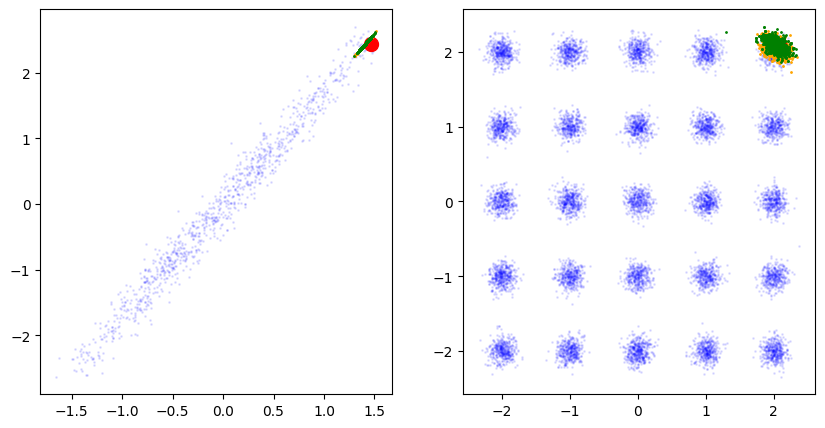

In [93]:
generated = importance_samples.detach().cpu()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
generated_projection = generated @ A.t().to('cpu')
posterior_projection = (posterior_samples @ A.T).cpu()
ax[0].scatter(posterior_projection[:,0], posterior_projection[:,1], label = 'posterior', s=1, color='orange')
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')


ax[1].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

In [94]:
effective_sample_size(importance_weights)/num_samples

tensor(0.7670, device='cuda:0')

In [95]:
## TDS-IS with low number of samples/particles

num_samples = 20
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)
generated = dps_sampling(exact_dm, num_samples, y.to(device), lambda x: x @ A.t(), EulerMaruyama(schedule), scale = "adaptive")

log_likelihood = -1/2*torch.sum((generated @ A.t() - y)**2, dim=1)/sigma_y**2 - 1/2*np.log(2*np.pi*sigma_y**2)

importance_weights = torch.softmax(log_likelihood, dim=0)

samples_idx = torch.multinomial(importance_weights, 40, replacement=True)

importance_samples = generated[samples_idx]

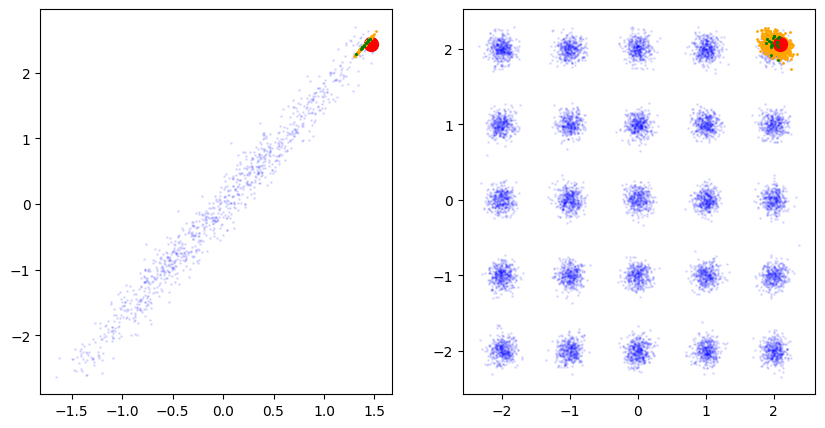

In [96]:
generated = importance_samples.detach().cpu()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(observation_prior.cpu()[:,0], observation_prior.cpu()[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
generated_projection = generated @ A.t().to('cpu')
posterior_projection = (posterior_samples @ A.T).cpu()
ax[0].scatter(posterior_projection[:,0], posterior_projection[:,1], label = 'posterior', s=1, color='orange')
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')


ax[1].scatter(baseline[:,0], baseline[:,1], label = 'baseline', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

In [97]:
effective_sample_size(importance_weights)/num_samples

tensor(0.8544, device='cuda:0')

## TDS

## MCGDiff

# Non Linear inverse problem

In [98]:
def soft_norm_regularization(x, alpha = 0.02):
    return x/(torch.norm(x, dim=1, keepdim=True) + alpha)

sigma_y = 0.03
forward_model = lambda x: soft_norm_regularization(x)
y = forward_model(x_truth) + torch.randn(1, 2).to(device)*sigma_y

In [99]:
## Evaluate true posterior using importance sampling with the prior as proposal

num_samples = 10000

prior_samples = sample(num_samples).to(device)

log_likelihood = -1/2*torch.sum((forward_model(prior_samples) - y)**2, dim=1)/sigma_y**2 - 1/2*np.log(2*np.pi*sigma_y**2)

importance_weights = torch.softmax(log_likelihood, dim=0)

samples_idx = torch.multinomial(importance_weights, 10000, replacement=True)

posterior_samples = prior_samples[samples_idx]

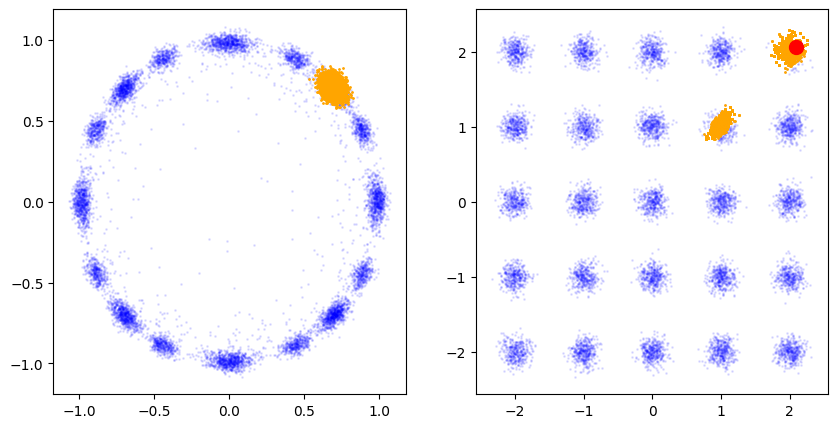

In [100]:
## Plot the projected prior and the true posterior as well as the observation y

importance_samples = importance_samples.cpu().detach()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
projected_prior = forward_model(prior_samples).cpu() + torch.randn(num_samples, 2).cpu()*sigma_y
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
projected_posterior = forward_model(posterior_samples).cpu() + torch.randn(10000, 2).cpu()*sigma_y
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')

In [101]:
## DPS
num_samples = 100
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)
generated = dps_sampling(exact_dm, num_samples, y.to(device), forward_model, EulerMaruyama(schedule), scale = "adaptive")

KeyboardInterrupt: 

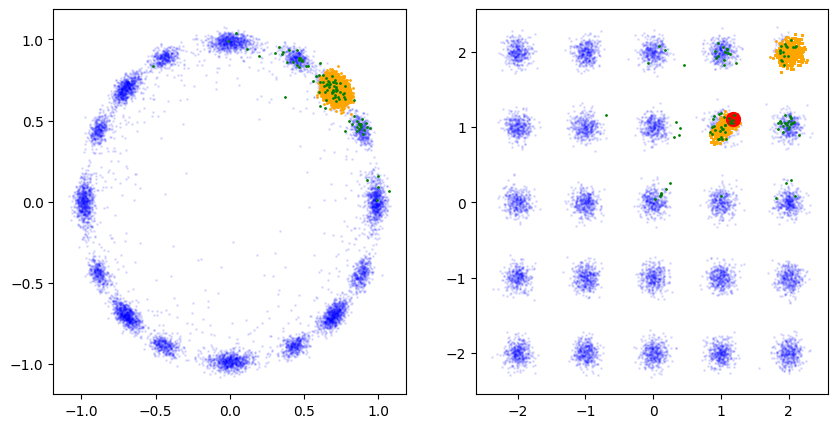

In [ ]:
## Plot DPS samples and their projections with all other relevant distributions

generated = generated.cpu().detach()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')
generated_projection = forward_model(generated).cpu() + torch.randn(num_samples, 2).cpu()*sigma_y
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

In [ ]:
## DPS-IS 
num_samples = 100
tmin = torch.ones(num_samples).to(device)*sde.tmin
tmax = torch.ones(num_samples).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)
generated = dps_sampling(exact_dm, num_samples, y.to(device), forward_model, EulerMaruyama(schedule), scale = "adaptive")

log_likelihood = -1/2*torch.sum((forward_model(generated) - y)**2, dim=1)/sigma_y**2 - 1/2*np.log(2*np.pi*sigma_y**2)

importance_weights = torch.softmax(log_likelihood, dim=0)

samples_idx = torch.multinomial(importance_weights, num_samples, replacement=True)

importance_samples = generated[samples_idx]

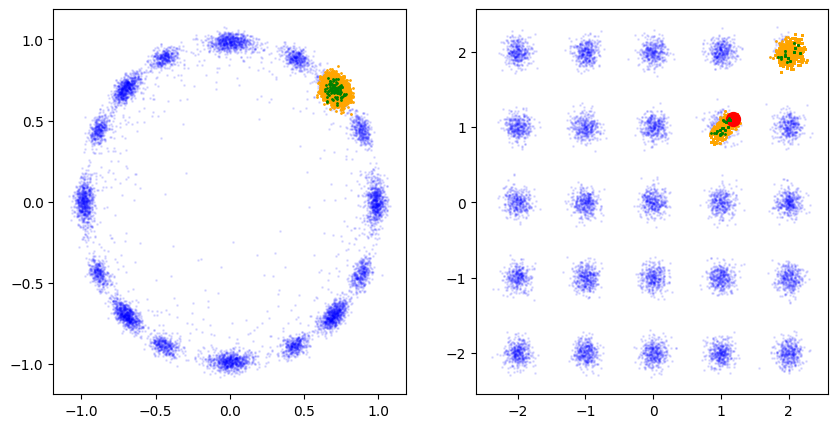

In [ ]:
## Plot DPS samples and their projections with all other relevant distributions

generated = importance_samples.cpu().detach()
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')
generated_projection = forward_model(generated).cpu() + torch.randn(num_samples, 2).cpu()*sigma_y
ax[0].scatter(generated_projection[:,0], generated_projection[:,1], label = 'generated', s=1, color='green')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(generated[:,0], generated[:,1], label = 'generated', s=1, color='green')

In [ ]:
effective_sample_size(importance_weights)/num_samples

tensor(0.3187, device='cuda:0')

# Blind Inverse Problem

In [ ]:
def blind_non_linear_operator(x,phi):
    y = soft_norm_regularization(x) # (b, ndim)
    diag_phi = torch.diag_embed(phi) # (b, ndim, ndim)
    return torch.einsum('bj, bij -> bi', y, diag_phi) # (b, ndim)

In [ ]:
phi_true = torch.tensor([1., 2.]).to(device).reshape(1, -1)

sigma_y = 0.03

forward_model_true = lambda x: blind_non_linear_operator(x, phi_true)

forward_model_blind = lambda x, phi: blind_non_linear_operator(x, phi)

y = forward_model_true(x_truth) + torch.randn(1, 2).to(device)*sigma_y

projected_prior = forward_model_true(prior_samples).cpu() + torch.randn(prior_samples.shape[0], 2).cpu()*sigma_y

In [ ]:
def log_prior_phi(phi):
    ## Uniform prior on [0.5, 2.5] for each component
    return torch.sum(torch.log((phi > 0.5) & (phi < 2.5)).to(torch.float32))

def sample_prior_phi(n_samples):
    return torch.rand(n_samples, 2).to(device)*2 + 0.5

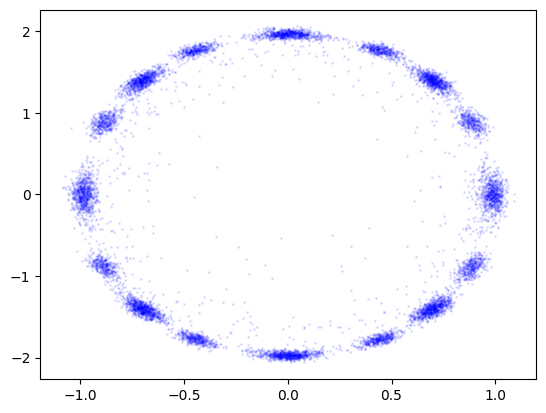

In [ ]:
## Plot the projected prior 

plt.scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)

In [ ]:
## Estimate the true posterior on (x,phi) using importance sampling with the prior as proposal for both x and phi

num_samples = 1000000

prior_samples = sample(num_samples).to(device)
prior_phi = sample_prior_phi(num_samples)

log_likelihood = -1/2*torch.sum((forward_model_blind(prior_samples, prior_phi) - y)**2, dim=1)/sigma_y**2 - 1/2*np.log(2*np.pi*sigma_y**2) ## Flat prior on phi

log_prior = log_prior_phi(prior_phi)

log_posterior = log_likelihood + log_prior

importance_weights = torch.softmax(log_posterior, dim=0)

samples_idx = torch.multinomial(importance_weights, 10000, replacement=True)

posterior_samples = prior_samples[samples_idx]
posterior_phi = prior_phi[samples_idx]

#Randomly select 10000 samples from the prior for plotting purposes
prior_samples = prior_samples[:10000]

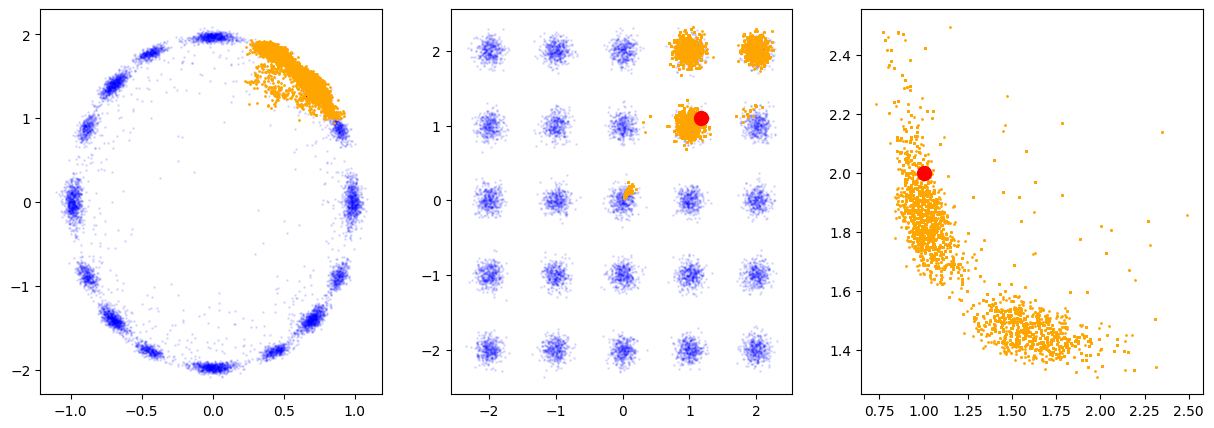

In [ ]:
## Plot the projected prior on x, the projected true posterior on x and the projected observation y
## Also plot the prior on x, the true posterior on x and x_truth
## Also plot the posterior on phi (flat prior)

importance_samples = posterior_samples.cpu().detach()
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
projected_prior = forward_model_true(prior_samples).cpu() + torch.randn(prior_samples.shape[0], ndim).cpu()*sigma_y
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
projected_posterior = forward_model_true(posterior_samples).cpu() + torch.randn(10000, ndim).cpu()*sigma_y
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')

#ax[2].scatter(prior_phi.cpu()[:,0], prior_phi.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[2].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[2].scatter(phi_true[:,0].to('cpu'), phi_true[:,1].to('cpu'), label = 'truth', s=100, color='red')


In [ ]:
## ESS of naive importance sampling method

effective_sample_size(importance_weights)/num_samples

tensor(0.0008, device='cuda:0')

## DPS + Gibbs sampling

In [ ]:
## Alternate between sampling x|phi, y using DPS and sampling phi|x,y using HMC

In [ ]:
phi_min = torch.tensor([0.5, 0.5]).to(device)
phi_max = torch.tensor([2.5, 2.5]).to(device)

coll_manager = lambda q, p, pnext: collision_manager(q, p, pnext, phi_min, phi_max)

bndry_proj = lambda q, p: boundary_projection(q, p, phi_min, phi_max)

In [ ]:
log_likelihood = lambda x, phi: -1/2*torch.sum((forward_model_blind(x, phi) - y)**2, dim=1)/sigma_y**2 - ndim/2*np.log(2*np.pi*sigma_y**2)
log_prior = lambda phi: log_prior_phi(phi)

def log_posterior(x, phi):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(x, phi) + log_prior(phi)

In [ ]:
N_MCMC = 50
N_SAMPLES = 500
tmin = torch.ones(N_SAMPLES).to(device)*sde.tmin
tmax = torch.ones(N_SAMPLES).to(device)*sde.tmax
schedule = linear_schedule(t_min = tmin, t_max = tmax, n_iter = 1000)
BURNIN_HEURISTIC_PHI = 1
phi_init = sample_prior_phi(N_SAMPLES)

phi_list = []
x_list = []
ess_list = []

importance_sampling = True

In [ ]:
progress_bar = tqdm.tqdm(total=N_MCMC)
phi = phi_init
phi_list.append(phi)
for i in range(N_MCMC):
    forward_model = lambda x: blind_non_linear_operator(x, phi)
    x_hat = dps_sampling(exact_dm, N_SAMPLES, y.to(device), forward_model, EulerMaruyama(schedule), scale = "adaptive")
    x_hat = x_hat.detach()
    if importance_sampling:
        log_likelihood_x = log_likelihood(x_hat, phi)
        importance_weights = torch.softmax(log_likelihood_x, dim=0)
        samples_idx = torch.multinomial(importance_weights, N_SAMPLES, replacement=True)
        x_hat = x_hat[samples_idx]
        ess_list.append(effective_sample_size(importance_weights))
    log_post = lambda phi : log_posterior(x_hat, phi)
    def log_prob_grad(phi):
        phi.requires_grad_(True)
        log_post_phi = log_post(phi)
        grad = torch.autograd.grad(log_post_phi, phi, grad_outputs=torch.ones_like(log_post_phi))[0]
        return log_post_phi.detach(), grad.detach()
    if i<BURNIN_HEURISTIC_PHI:
        hmc = HMC(log_post, log_prob_and_grad=log_prob_grad)
        hmc.set_collision_fn(coll_manager)
        samples = hmc.sample(phi, nsamples=1, burnin=1, step_size=1e-4, nleap=(5,15), epsadapt=100, verbose=False, ret_side_quantities=False)
        step_size = hmc.step_size
        inv_mass_matrix = hmc.mass_matrix_inv
    else:
        hmc = HMC(log_post, log_prob_and_grad=log_prob_grad)
        hmc.set_collision_fn(coll_manager)
        hmc.set_inv_mass_matrix(inv_mass_matrix, batch_dim=True)
        samples = hmc.sample(phi, nsamples=1, burnin=10, step_size=step_size, nleap = (5,15), epsadapt=0, verbose = False, ret_side_quantities=False)
    phi = samples[:,-1,:].detach()
    phi_list.append(phi)
    x_list.append(x_hat)
    progress_bar.update(1)
progress_bar.close()

  0%|          | 0/50 [00:00<?, ?it/s]

Adapting step size using 100 iterations


  2%|▏         | 1/50 [00:03<02:52,  3.51s/it]

Step size fixed to :  tensor([0.1447, 0.1403, 0.1485, 0.1398, 0.1244, 0.1466, 0.1142, 0.1698, 0.1439,
        0.1311, 0.1059, 0.1486, 0.1227, 0.1250, 0.1432, 0.1336, 0.1414, 0.1531,
        0.1278, 0.0980, 0.1231, 0.1205, 0.1052, 0.1015, 0.1031, 0.1839, 0.1792,
        0.1368, 0.1100, 0.1105, 0.1585, 0.1583, 0.1384, 0.1209, 0.1245, 0.1332,
        0.1277, 0.1307, 0.1297, 0.1134, 0.1447, 0.1210, 0.1271, 0.1504, 0.1148,
        0.1578, 0.1350, 0.1148, 0.1540, 0.1198, 0.1208, 0.1082, 0.1331, 0.1481,
        0.1042, 0.1697, 0.1404, 0.1181, 0.1275, 0.1274, 0.1594, 0.1108, 0.1122,
        0.1260, 0.1367, 0.1430, 0.1259, 0.1749, 0.1343, 0.1151, 0.1286, 0.1194,
        0.1285, 0.1454, 0.1143, 0.1448, 0.1195, 0.1436, 0.1709, 0.1134, 0.1079,
        0.1539, 0.1233, 0.1382, 0.1373, 0.1137, 0.1394, 0.1357, 0.1281, 0.1436,
        0.1236, 0.1498, 0.1180, 0.1095, 0.1415, 0.1195, 0.1364, 0.1369, 0.1421,
        0.1485, 0.1244, 0.1186, 0.1555, 0.1103, 0.1770, 0.1376, 0.1149, 0.1392,
        0.1287, 0.

 36%|███▌      | 18/50 [00:43<01:13,  2.31s/it]

KeyboardInterrupt: 

In [ ]:
x_chains = [x.detach().unsqueeze(0) for x in x_list]
x_chains = torch.cat(x_chains, dim=0)

phi_chains = [phi.detach().unsqueeze(0) for phi in phi_list]
phi_chains = torch.cat(phi_chains, dim=0)

In [ ]:
x_chains.shape, phi_chains.shape

(torch.Size([50, 500, 2]), torch.Size([51, 500, 2]))

In [ ]:
burnin = 10 
x_chains = x_chains[burnin:]
phi_chains = phi_chains[burnin:]

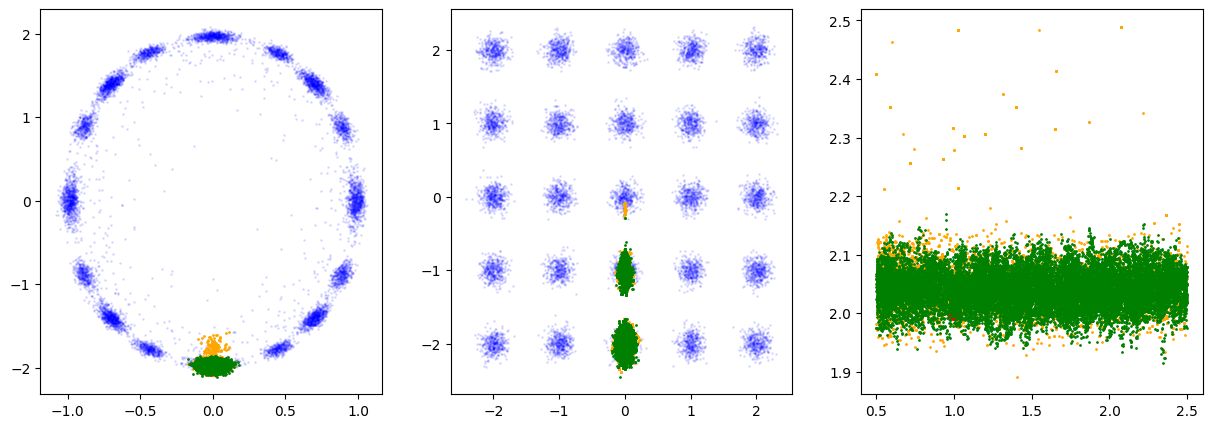

In [ ]:
## Plot the estimated posterior on x and phi vs the true posterior and the prior

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
projected_prior = forward_model_true(prior_samples).cpu() + torch.randn(prior_samples.shape[0], ndim).cpu()*sigma_y
ax[0].scatter(projected_prior[:,0], projected_prior[:,1], label='prior', color='blue', s=1, alpha = 0.1)
ax[0].scatter(y.cpu()[:,0], y.cpu()[:,1], label = 'truth', s=100, color='red')
projected_posterior = forward_model_true(posterior_samples).cpu() + torch.randn(10000, ndim).cpu()*sigma_y
ax[0].scatter(projected_posterior[:,0], projected_posterior[:,1], label = 'posterior', s=1, color='orange')
estimated_posterior = x_chains.reshape(-1, ndim)
projected_estimated_posterior = forward_model_true(estimated_posterior).cpu() + torch.randn(estimated_posterior.shape[0], ndim).cpu()*sigma_y
ax[0].scatter(projected_estimated_posterior[:,0], projected_estimated_posterior[:,1], label = 'estimated posterior', s=1, color='green')

ax[1].scatter(prior_samples.cpu()[:,0], prior_samples.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[1].scatter(posterior_samples.cpu().detach()[:,0], posterior_samples.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[1].scatter(x_truth[:,0].to('cpu'), x_truth[:,1].to('cpu'), label = 'truth', s=100, color='red')
ax[1].scatter(estimated_posterior[:,0].cpu(), estimated_posterior[:,1].cpu(), label = 'estimated posterior', s=1, color='green')
#ax[2].scatter(prior_phi.cpu()[:,0], prior_phi.cpu()[:,1], label = 'prior', s=1, alpha = 0.1, color='blue')
ax[2].scatter(posterior_phi.cpu().detach()[:,0], posterior_phi.cpu().detach()[:,1], label = 'posterior', s=1, color='orange')
ax[2].scatter(phi_true[:,0].to('cpu'), phi_true[:,1].to('cpu'), label = 'truth', s=100, color='red')
estimated_phi_posterior = phi_chains.reshape(-1, 2).cpu()
ax[2].scatter(estimated_phi_posterior[:,0], estimated_phi_posterior[:,1], label = 'estimated posterior', s=1, color='green')


Text(0.5, 1.0, 'Estimated posterior on phi')

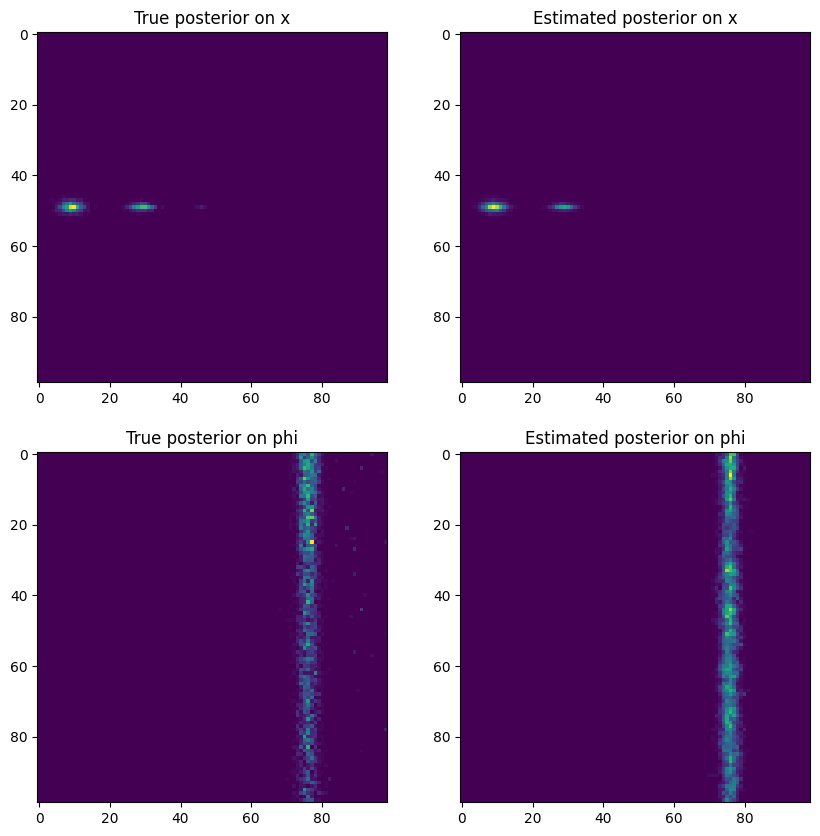

In [ ]:
## Estimated posterior density vs true posterior density on both x and phi

fig, ax = plt.subplots(2,2, figsize = (10, 10))
bins_x_1 = np.linspace(-2.5, 2.5, 100)
bins_x_2 = np.linspace(-2.5, 2.5, 100)
bins_phi_1 = np.linspace(0.5, 2.5, 100)
bins_phi_2 = np.linspace(0.5, 2.5, 100)
hist_post_x_true = np.histogram2d(posterior_samples.cpu().numpy()[:,0], posterior_samples.cpu().numpy()[:,1], bins = (bins_x_1, bins_x_2))
hist_post_x_estimated = np.histogram2d(estimated_posterior.cpu().numpy()[:,0], estimated_posterior.cpu().numpy()[:,1], bins = (bins_x_1, bins_x_2))
hist_post_phi_true = np.histogram2d(posterior_phi.cpu().numpy()[:,0], posterior_phi.cpu().numpy()[:,1], bins = (bins_phi_1, bins_phi_2))
hist_post_phi_estimated = np.histogram2d(estimated_phi_posterior.cpu().numpy()[:,0], estimated_phi_posterior.cpu().numpy()[:,1], bins = (bins_phi_1, bins_phi_2))

ax[0,0].imshow(hist_post_x_true[0])
ax[0,0].set_title('True posterior on x')
ax[0,1].imshow(hist_post_x_estimated[0])
ax[0,1].set_title('Estimated posterior on x')
ax[1,0].imshow(hist_post_phi_true[0])
ax[1,0].set_title('True posterior on phi')
ax[1,1].imshow(hist_post_phi_estimated[0])
ax[1,1].set_title('Estimated posterior on phi')


In [ ]:
ess_list = [ess.item() for ess in ess_list]

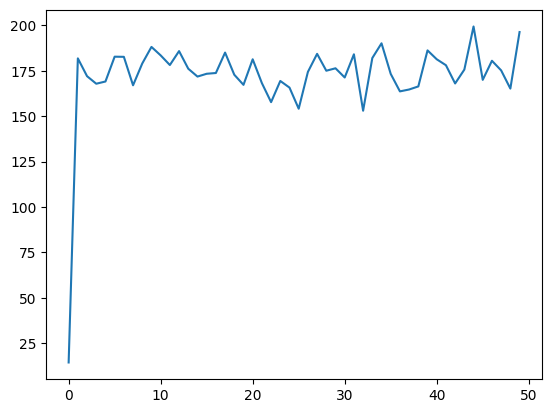

In [ ]:
plt.plot(ess_list)

Chains on $\phi$ do not mix well and some of them are stuck in local minimas. A better initialization might help but this proves that the method is not robust.

In turn the fact we do not reach convergence on $\phi$ means that we do not reach convergence on $x$.